## 1. Preliminary

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import yaml
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")
from utils import load_paper_node, load_paper_edge

## 2. Load and inspect the paper

In [3]:
# Load config file and get the path of csv files
with open("./config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
PAPER_NODE = Path(config["data"]["paper"]["node"])
PAPER_EDGE = Path(config["data"]["paper"]["edge"])

In [4]:
df_node = load_paper_node(PAPER_NODE, False)    # The NAs in df will not be filled with empty string

2024-12-11 16:59:01 - SocialNetwork - INFO - Load data\paper\node.csv as dataframe, memory usage 1579.10 MB
2024-12-11 16:59:01 - SocialNetwork - INFO - Function 'load_paper_node' executed in 17.35 second(s)


In [5]:
df_node.info()
df_node.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680007 entries, 0 to 3680006
Data columns (total 7 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   id       string
 1   title    string
 2   authors  object
 3   year     Int16 
 4   venue    string
 5   out_d    int16 
 6   in_d     int16 
dtypes: Int16(1), int16(2), object(1), string(3)
memory usage: 136.9+ MB


,id,title,authors,year,venue,out_d,in_d
0,555036b37cea80f954149ffc,Approximate Distance Oracles with Improved Que...,[287837],2015,Encyclopedia of Algorithms,0,0
1,555036b37cea80f954149ffd,Subset Sum Algorithm for Bin Packing.,[855925],2015,Encyclopedia of Algorithms,0,0
2,555036b37cea80f954149ffe,Minimum Weighted Completion Time.,"[1714844, 1038326, 1578020, 140095]",2015,Encyclopedia of Algorithms,0,0
3,555036b37cea80f954149fff,Multiple String Matching.,"[1124727, 1658178]",2015,Encyclopedia of Algorithms,0,0
4,555036b37cea80f95414a000,Fault-Tolerant Connected Dominating Set.,"[407556, 1756780, 1760018, 47850]",2015,Encyclopedia of Algorithms,0,0


## 3. Count NaN values

In [6]:
df_node.loc[df_node['year'] == 0, 'year'] = np.nan
nan_counts = df_node.isna().sum()
print(nan_counts)

id             0
title          0
authors    52010
year           7
venue      56785
out_d          0
in_d           0
dtype: int64


## 4. Plot the distribution of list columns

In [7]:
# Handle the NAs in `authors`
df_node["authors"] = df_node["authors"].apply(lambda x: x if isinstance(x, list) else [])

# Calculate the number of authors and references for each row
df_node["num_authors"] = df_node["authors"].apply(len)

# Calculate basic statistics
print(df_node["num_authors"].describe())
print("=" * 20)
print(df_node["out_d"].describe())
print("=" * 20)
print(df_node["in_d"].describe())

count    3.680007e+06
mean     2.836479e+00
std      1.748325e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.390000e+02
Name: num_authors, dtype: float64
count    3.680007e+06
mean     5.097998e-01
std      1.294739e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      6.090000e+02
Name: out_d, dtype: float64
count    3.680007e+06
mean     5.097998e-01
std      1.059119e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.067000e+03
Name: in_d, dtype: float64


count    3.626640e+06
mean     2.867512e+00
std      1.640951e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      2.000000e+01
Name: num_authors, dtype: float64


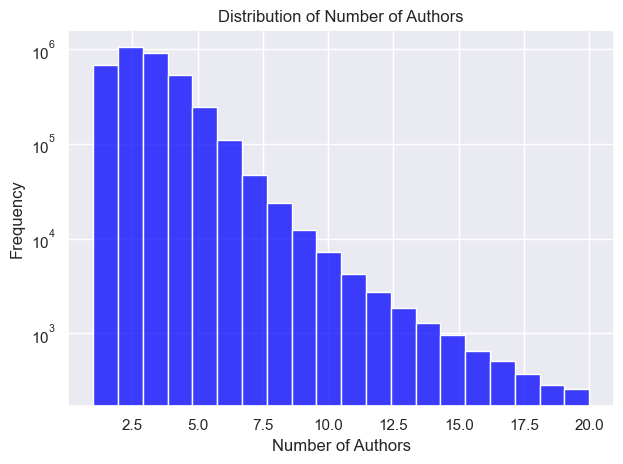

In [8]:
df_filtered_authors = df_node[(df_node['num_authors'] > 0) & (df_node['num_authors'] <= 20)]
print(df_filtered_authors["num_authors"].describe())

# Plot the distribution of the number of authors
sns.histplot(df_filtered_authors['num_authors'], color='blue', bins=20)
plt.title('Distribution of Number of Authors')
plt.xlabel('Number of Authors')
plt.ylabel('Frequency')
plt.yscale("log")
plt.tight_layout()
plt.show()

count    1.773552e+06
mean     1.050111e+00
std      1.073527e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.900000e+01
Name: out_d, dtype: float64


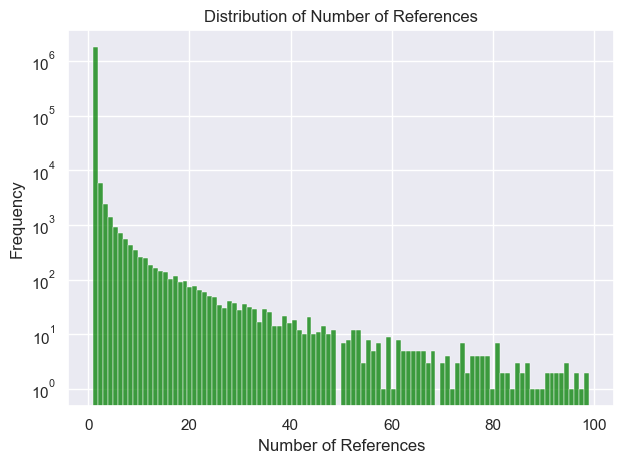

In [9]:
df_filtered_out_d = df_node[(df_node['out_d'] > 0) & (df_node['out_d'] <= 100)]
print(df_filtered_out_d["out_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_out_d['out_d'], color='green', bins=100)
plt.title('Distribution of Number of References')
plt.xlabel('Number of References')
plt.ylabel('Frequency')
plt.yscale("log")
plt.tight_layout()
plt.show()

count    35162.000000
mean        29.818099
std         22.514989
min          1.000000
25%         13.000000
50%         23.000000
75%         41.000000
max        100.000000
Name: in_d, dtype: float64


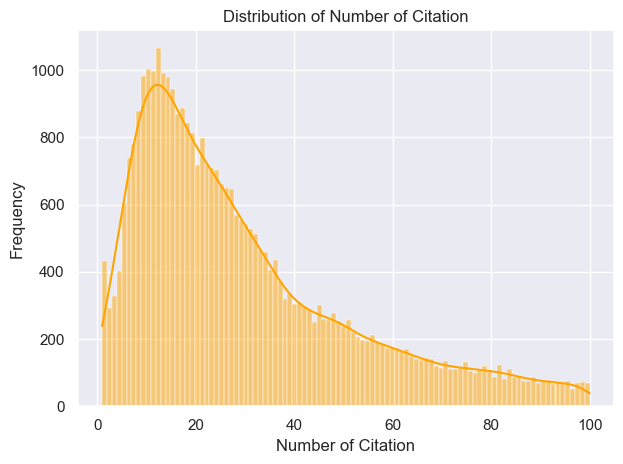

In [10]:
df_filtered_in_d = df_node[(df_node['in_d'] > 0) & (df_node['in_d'] <= 100)]
print(df_filtered_in_d["in_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_in_d['in_d'], color='orange', kde=True, bins=100)
plt.title('Distribution of Number of Citation')
plt.xlabel('Number of Citation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 5. Probe other columns

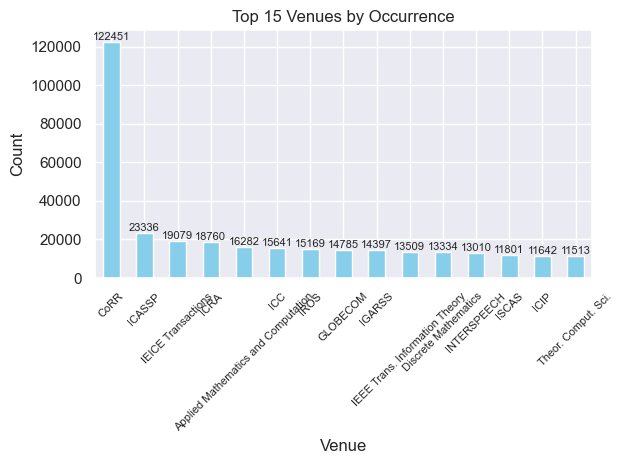

In [11]:
# Get the unique venues and their occurrences
venue_counts = df_node['venue'].value_counts()

# Get the first 15 items
top_15_venues = venue_counts.head(15)

# Plot the first 15 venues
top_15_venues.plot(kind='bar', color='skyblue')
plt.title('Top 15 Venues by Occurrence')
plt.xlabel('Venue')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=8)
plt.xticks(rotation=45, fontsize=8)
for i, count in enumerate(top_15_venues):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

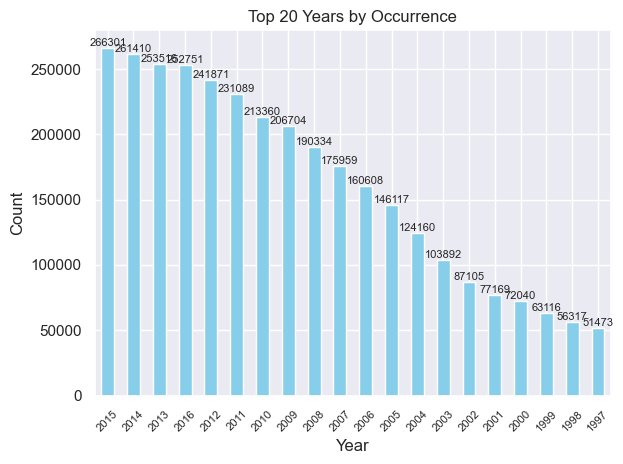

In [12]:
# Get the unique venues and their occurrences
year_counts = df_node['year'].value_counts()

top_20_years = year_counts.head(20)

# Plot the first 20 years
top_20_years.plot(kind='bar', color='skyblue')
plt.title('Top 20 Years by Occurrence')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=8)
for i, count in enumerate(top_20_years):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

## 6. Visualize the edges

2024-12-11 16:59:11 - SocialNetwork - INFO - Load data\paper\edge.csv as dataframe, memory usage 289.84 MB
2024-12-11 16:59:11 - SocialNetwork - INFO - Function 'load_paper_edge' executed in 1.76 second(s)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876067 entries, 0 to 1876066
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   src     string
 1   dst     string
dtypes: string(2)
memory usage: 28.6 MB


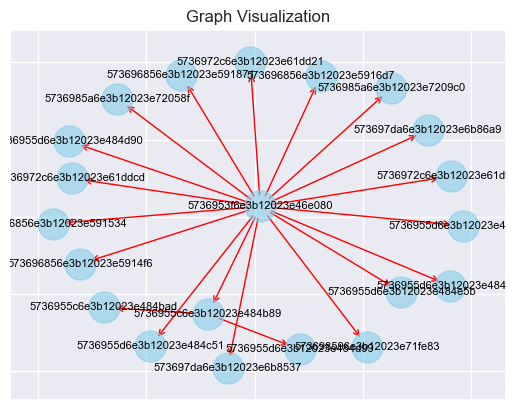

In [13]:
df_edge = load_paper_edge(PAPER_EDGE)
df_edge.info()
# Create a graph using NetworkX
G = nx.from_pandas_edgelist(df_edge, source='src', target='dst', create_using=nx.DiGraph())

# Get a subset of edges
subgraph_edges = list(G.edges())[:20] 
subgraph = G.edge_subgraph(subgraph_edges)
pos = nx.spring_layout(subgraph)

# Plot the graph
nx.draw_networkx_nodes(subgraph, pos, node_size=500, node_color="skyblue", alpha=0.6)
nx.draw_networkx_edges(subgraph, pos, edge_color="red", arrows=True, arrowsize=10, arrowstyle='->')
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")
plt.title("Graph Visualization")
plt.show()

## 7. Inspect the author node and edges

In [14]:
from utils import load_author_node, load_author_edge

AUTHOR_NODE = config["data"]["author"]["node"]
AUTHOR_EDGE = config["data"]["author"]["edge"]

df_node = load_author_node(AUTHOR_NODE, False).iloc[2:]
df_edge = load_author_edge(AUTHOR_EDGE)

2024-12-11 16:59:37 - SocialNetwork - INFO - Load ./data/author/node.csv as dataframe, memory usage 821.52 MB
2024-12-11 16:59:37 - SocialNetwork - INFO - Function 'load_author_node' executed in 18.38 second(s)
2024-12-11 16:59:44 - SocialNetwork - INFO - Load ./data/author/edge.csv as dataframe, memory usage 1030.36 MB
2024-12-11 16:59:44 - SocialNetwork - INFO - Function 'load_author_edge' executed in 7.09 second(s)


In [15]:
df_node.info()
df_node.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904246 entries, 2 to 1904247
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   id          int64 
 1   name        string
 2   co-authors  object
 3   papers      object
dtypes: int64(1), object(2), string(1)
memory usage: 58.1+ MB


,id,name,co-authors,papers
2,3,(Max) Zong-Ming Cheng,"[197514, 229313, 319300, 341810, 411771, 54713...","[573695ab6e3b12023e4ca167, 573695ab6e3b12023e4..."
3,4,(Zhou) Bryan Bai,[1580950],"[573698766e3b12023e737002, 573696f96e3b12023e5..."
4,5,A Lun,"[598680, 1813742, 1837042]",[573696f86e3b12023e5f3e82]
5,6,A Min Tjoa,"[21424, 25842, 39524, 65557, 66578, 84768, 847...","[573697b16e3b12023e6939d4, 555037a47cea80f9541..."
6,7,A'ang Subiyakto,"[22968, 1175140, 1620699]",[58437707ac44360f1082b3ed]


In [16]:
print(df_node.isna().sum())

id                0
name              0
co-authors    94703
papers            0
dtype: int64


count    1.904246e+06
mean     8.805587e+00
std      2.178874e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      3.851000e+03
Name: num_co_authors, dtype: float64


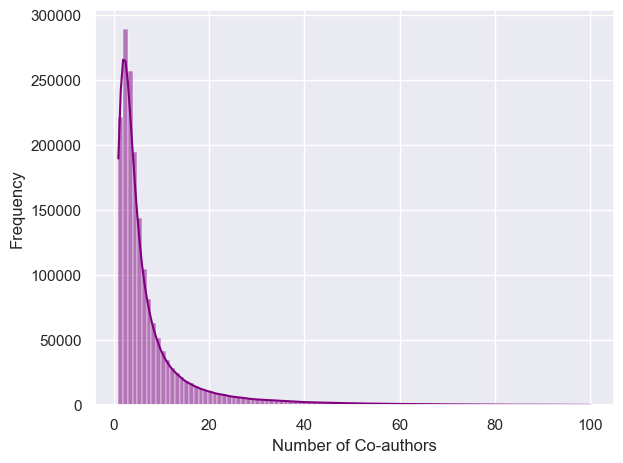

In [17]:
df_node['num_co_authors'] = df_node['co-authors'].apply(lambda x: len(x) if isinstance(x, list) else 0)
print(df_node['num_co_authors'].describe())
df_filtered_num_co_authors = df_node[(df_node["num_co_authors"] > 0) & (df_node["num_co_authors"] <= 100)]

sns.histplot(df_filtered_num_co_authors['num_co_authors'], color='purple', kde=True, bins=100)
plt.xlabel('Number of Co-authors')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

count    1.904246e+06
mean     5.481235e+00
std      1.792932e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      2.668000e+03
Name: num_papers, dtype: float64


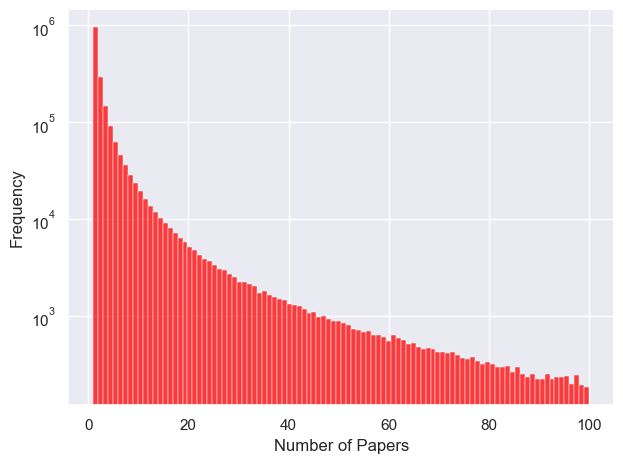

In [18]:
df_node['num_papers'] = df_node['papers'].apply(lambda x: len(x))
print(df_node["num_papers"].describe())
df_filtered_num_papers = df_node[(df_node["num_papers"] > 0) & (df_node["num_papers"] <= 100)]

sns.histplot(df_filtered_num_papers['num_papers'], color='red', bins=100)
plt.xlabel('Number of Papers')
plt.ylabel('Frequency')
plt.yscale("log")
plt.tight_layout()
plt.show()

In [19]:
# Filter rows where num_papers > 4000
rows_with_large_papers = df_node[df_node['papers'].apply(lambda x: len(x) > 2000 if isinstance(x, list) else False)]

# Display the filtered rows
print(rows_with_large_papers)

              id      name                                         co-authors  \
1756779  1756780  Wei Wang  [21, 3280, 6737, 8878, 18145, 22287, 22967, 25...   

                                                    papers  num_co_authors  \
1756779  [573695d96e3b12023e4f0e3a, 555036e67cea80f9541...            3851   

         num_papers  
1756779        2668  


In [20]:
df_edge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384576 entries, 0 to 8384575
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   src     string
 1   dst     string
 2   w       int16 
dtypes: int16(1), string(2)
memory usage: 143.9 MB


 98%|█████████▊| 49/50 [00:00<00:00, 62.13it/s]


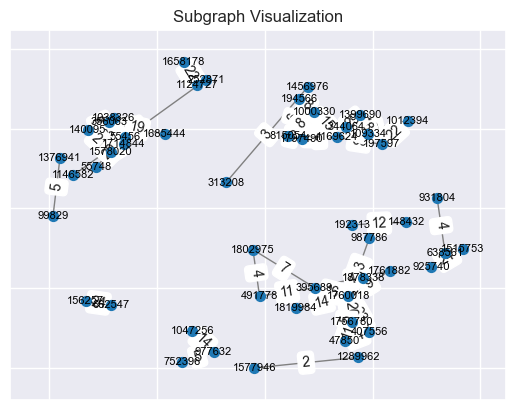

In [21]:
from tqdm import tqdm

# Create a subgraph from the desired edges
subgraph = nx.Graph()
count = 0
for _, row in tqdm(df_edge.iterrows(), total=50):
    subgraph.add_edge(row['src'], row['dst'], weight=row['w'])
    count += 1
    if count == 50:
        break


# Plot the subgraph
pos = nx.spring_layout(subgraph, seed=42, k=1)

nx.draw_networkx_nodes(subgraph, pos, node_size=50)
nx.draw_networkx_edges(subgraph, pos, edge_color="gray")
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")

# Add edge labels (weights)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

plt.title("Subgraph Visualization")
plt.show()